# Packages, constants & functions

In [ ]:
%%capture

utils = {
    'GridProperties.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/GridProperties.py',
    'GSModel.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/GSModel.py',
    'GridSearchParameters.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/GridSearchParameters.py'
}

RF_utils = {
    'RFGridProperties.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/RFModel/RFGridProperties.py',
    'RFSearchParameters.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/RFModel/RFSearchParameters.py',
    'RandomForestModel.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/RFModel/RandomForestModel.py'
}

SVM_utils = {
    'SVMGridProperties.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/SVMModel/SVMGridProperties.py',
    'SVMModel.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/SVMModel/SVMModel.py',
    'SVMSearchParameters.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/SVMModel/SVMSearchParameters.py'
}

DT_utils = {
    'DTGridProperties.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/DTModel/DTGridProperties.py',
    'DTModel.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/DTModel/DTModel.py',
    'DTSearchParameters.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/DTModel/DTSearchParameters.py'
}

XGB_utils = {
    'XGBGridProperties.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/XGBModel/XGBGridProperties.py',
    'XGBModel.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/XGBModel/XGBModel.py',
    'XGBSearchParameters.py': 'https://raw.githubusercontent.com/PashaIanko/ClothesClassifier/main/XGBModel/XGBSearchParameters.py'
}

def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}


download_files(utils)
download_files(RF_utils)
download_files(SVM_utils)
download_files(DT_utils)
download_files(XGB_utils)

In [ ]:
class DataProperties:
    num_classes = 10
    img_width = 28
    img_height = 28
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    translation = {
        0: 'T-shirt',
        1: 'Trouser', 
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal', 
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot'
    }
    seed = 12

    def translate_labels(labels):
        return [DataProperties.translation[num] for num in labels]
    
    def translate_label(class_num):
        return DataProperties.translation[class_num]

In [ ]:
%%capture 
!pip install nose

In [ ]:
# Data download & utils
import numpy as np
from urllib.request import urlopen
from skimage import filters
import pandas as pd

# Testing
from nose.tools import assert_equal

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support as prec_rec_f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin

# My classes
from GridProperties import GridProperties
from GSModel import GSModel
from GridSearchParameters import GridSearchParameters

# RandomForest model
from RFGridProperties import RFGridProperties
from RFSearchParameters import RFSearchParameters
from RandomForestModel import RandomForestModel

# SVMModel
from SVMGridProperties import SVMGridProperties
from SVMSearchParameters import SVMSearchParameters
from SVMModel import SVMModel

# DecisionTreeModel
from DTGridProperties import DTGridProperties
from DTSearchParameters import DTSearchParameters
from DTModel import DTModel

# GradientBoostingModel
from XGBGridProperties import XGBGridProperties
from XGBSearchParameters import XGBSearchParameters
from XGBModel import XGBModel

# FFNN Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework.random_seed import set_random_seed
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
def load_fashion_mnist():
    url_base = "https://www.math.unipd.it/~dasan/"
    Y_train = np.frombuffer(urlopen(url_base + "train-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_train = np.frombuffer(urlopen(url_base + "train-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_train), 784) # besides loadng 
                                                                                            #the data, I already flatten it into a vector
    Y_test = np.frombuffer(urlopen(url_base + "t10k-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_test = np.frombuffer(urlopen(url_base + "t10k-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(Y_test), 784)

    return X_train, Y_train, X_test, Y_test

In [ ]:
def plot_class(class_n, X, Y, figsize = (10, 10), matsize = (3, 3)):
    fig, axes = plt.subplots(matsize[0], matsize[1], figsize = figsize)
    fig.suptitle(f'Image of instances of Class №{class_n} ({DataProperties.translate_label(class_n)})')
    
    class_instances = X[Y == class_n]
    counter = 0
    for i in range(matsize[0]):
        for j in range(matsize[1]):
            axes[i, j].imshow(
                class_instances[counter].reshape(
                    DataProperties.img_height, 
                    DataProperties.img_width
                )
            )
            counter += 1

In [ ]:
def compare_pixel_dist(X, Y, classes, sample_size):
    fig = plt.figure(figsize = (8, 5))
    for c in classes:
        sample = X[Y == c][:sample_size]
        sns.distplot(
            sample, 
            hist = False, 
            label = f'Class {c}: {DataProperties.translate_label(c)}')
    plt.title('Pixel greyscale value distribution')
    fig.legend()

In [ ]:
class Reshaper(BaseEstimator, TransformerMixin):
    """
    Reshape from linear to 
    square image
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array(X).reshape(X.shape[0], DataProperties.img_height, DataProperties.img_width)

In [ ]:
class Flatter(BaseEstimator, TransformerMixin):
    """
    Flat an image from 3D to 2D
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array(X).reshape(len(X), -1)

In [ ]:
class EdgeHighlighter(BaseEstimator, TransformerMixin):
    """
    Highlight edges
    """
 
    def __init__(self, add_coef):
        self.add_coef = add_coef
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        edges = filters.sobel(X)
        return X + self.add_coef * edges

In [ ]:
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=8,
                 pixels_per_cell=(2, 2),
                 cells_per_block=(1, 1), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
def get_best_scores(cross_val_results):
    res = {}
    for name, cv_res in cross_val_results.items():
        res[name] = cv_res.best_score_
    return {k: v for k, v in sorted(res.items(), key = lambda item: item[1])}

def plot_best_scores(scores_dict, y_label, title):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylabel(y_label)
    ax.set_title(title)

    x_vals = best_scores.keys()
    y_vals = best_scores.values()
    
    ax.bar(x_vals, y_vals)
    plt.show()

In [ ]:
def plot_cv_metrics(cross_val_res, metrics_name, figsize, layout_shape):
    n_models = len(cross_val_res)
    n_rows_cols = int(np.sqrt(n_models))
    
    fig, axes = plt.subplots(
        layout_shape[0],
        layout_shape[1],
        sharex = False,
        sharey = False,
        figsize = figsize
    )

    counter = 0
    for model_name, res in cross_val_res.items():
        row = counter % n_rows_cols
        col = counter // n_rows_cols
        
        if n_rows_cols == 1:
            ax = axes[counter]
        else:
            ax = axes[row, col]

        model_res = cross_val_res[model_name].cv_results_
        train_res = model_res['mean_train_' + metrics_name]
        test_res = model_res['mean_test_' + metrics_name]
        cv_epochs = np.arange(1, len(train_res) + 1)

        ax.bar(cv_epochs, train_res)
        ax.bar(cv_epochs, test_res)
        ax.set_title(f'CV results for {model_name}: {metrics_name}')
        ax.set_xlabel('№ CV step')
        ax.set_ylabel(f'Metrics: {metrics_name}')

        ax.legend(['Train', 'Test'])

        counter += 1

In [ ]:
def plot_confusion_matrix(model, model_name, X_test, Y_test, figsize):
    fig, axes = plt.subplots(1, 1, figsize = figsize)

    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        Y_test,
        xticks_rotation = 'vertical',
        display_labels = DataProperties.translate_labels(model.classes_),
        cmap = 'Oranges',
        normalize = 'true',
        ax = axes
    )
    plt.title(f'Normalized confusion matrix for {model_name}')
    plt.show()

In [ ]:
def plot_learning_curve(model, model_name, X, Y, train_sizes, cv, scoring, metrics_name):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator = model,
        X = X,
        y = Y,
        train_sizes = train_sizes,
        cv = cv,
        scoring = scoring
    )
    
    plt.figure(figsize=(7, 5))
    plt.plot(
        train_sizes, 
        train_scores.mean(axis=1), 
        label=f'{metrics_name}: Mean CV train scores',
        linestyle = 'dashed',
        marker = 'o',
        markerfacecolor = 'white',
        markersize = 9
    )
    plt.plot(
        train_sizes, 
        validation_scores.mean(axis=1), 
        label=f'{metrics_name}: Mean CV validation scores',
        marker = 'o',
        markerfacecolor = 'white',
        markersize = 9
    )
    plt.ylabel(f'{metrics_name} scores')
    plt.xlabel('Train size')
    plt.grid()
    plt.title(f'Learning curve for {model_name}')
    plt.legend()

In [ ]:
def plot_nn_learning_curve(history, metrics_name, val_metrics_name):
    plt.plot(
        history[metrics_name],
        marker = 'o',
        markerfacecolor = 'white',
        markersize = 7
    )

    plt.plot(
        history[val_metrics_name],
        marker = 'o',
        markerfacecolor = 'white',
        markersize = 7
    )

    plt.title(f'FFNN model, {metrics_name} metrics')
    plt.ylabel(metrics_name)
    plt.xlabel('Epoch number')
    plt.grid()
    plt.legend(['Train', 'Validation'], loc = 'best')
    plt.show()

In [ ]:
def plot_mistaken_images(true_label, mistaken_label, mistakes_percent, X, Y_true, Y_pred, model_name, layout_size = 2):
    indices = np.all(
        [
         (Y_true == true_label),
         (Y_pred == mistaken_label)
        ],
        axis = 0
    )

    _, axes = plt.subplots(
        nrows = 1, 
        ncols = layout_size, 
        figsize = (10, 3)
    )
    for ax, image, label, pred_label in zip(axes, X[indices][: layout_size], Y_true[indices][: layout_size], Y_pred[indices][: layout_size]):
        ax.set_axis_off()
        ax.imshow(
            image.reshape(DataProperties.img_height, DataProperties.img_width), 
            cmap=plt.cm.gray_r, 
            interpolation="nearest"
        )
        ax.set_title(f"""
            Model name: {model_name}
            True label: {true_label} ({DataProperties.translate_label(true_label)})\n
            Mistaken label: {mistaken_label} ({DataProperties.translate_label(mistaken_label)})\n
            Mistakes %: {np.round(mistakes_percent * 100, 2)}"""
        )

In [ ]:
def plot_mistakes(best_estimator, model_name, X, Y_true, Y_predicted, top_n):
    conf_mat = confusion_matrix(
        Y_true,
        Y_predicted,
        labels = best_estimator.classes_,
        normalize = 'true'
    )
    
    for label in DataProperties.classes:
        true_label = label
        predicted_labels = conf_mat[true_label]

        top_mistaken_labels = np.argsort(predicted_labels)[::-1][1 : top_n + 1]
        top_percentages = np.sort(predicted_labels)[::-1][1 : top_n + 1]
    
        for i in range(len(top_mistaken_labels)):
            mistaken_label = top_mistaken_labels[i]
            mistakes_percent = top_percentages[i]
            plot_mistaken_images(
                true_label, 
                mistaken_label, 
                mistakes_percent,
                X, 
                Y_true, 
                Y_predicted,
                model_name
            )

In [ ]:
def collect_classif_reports(estimators_dict, X, Y):
    res = {}
    for name, estimator in estimators_dict.items():
        if name == 'NeuralNetwork':
            pred = estimator.predict(X).argmax(axis = 1)
        else:
            pred = estimator.predict(X)
        precision, recall, fscore, _ = prec_rec_f1_score(
            Y,
            pred,
            average = 'macro'  # Because dataset is balanced
        )
        accuracy = accuracy_score(Y, pred)
        res[name] = {
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1': fscore
        }
    precisions = {name: item['Precision'] for name, item in res.items()}
    recalls = {name: item['Recall'] for name, item in res.items()}
    accuracies = {name: item['Accuracy'] for name, item in res.items()}
    F1 = {name: item['F1'] for name, item in res.items()}
    return precisions, recalls, accuracies, F1

# Data download

- Here, we split data into three sets:
    - Train + validation
    - Test
- Test set remains untouched. Further, we split Train + validation set, in order to choose best model on unseen validation data. Best model results are reported on the unseen data from the test set.

In [31]:
subset_size = 6000

X_train_val, Y_train_val, X_test, Y_test = load_fashion_mnist()

X_train_val = X_train_val[ : subset_size]
Y_train_val = Y_train_val[ : subset_size]

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_val,
    Y_train_val,
    stratify = Y_train_val,
    train_size = 0.9
)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

(2700, 784) (2700,) (300, 784) (300,) (10000, 784) (10000,)


# Data clean check

- Make sure, that data is clean and does not contain missing pixels

In [32]:
# Check missing pixels
def check_nan(arr):
    assert_equal(np.isnan(arr).any(), False)

check_nan(X_train)
check_nan(X_val)
check_nan(X_test)

check_nan(Y_train)
check_nan(Y_val)
check_nan(Y_test)

# Data exploration

### Class presence in Train & Test

- Make sure all range of classes is present in all datasets

In [33]:
train_vals = np.unique(Y_train)
val_vals = np.unique(Y_val)
test_vals = np.unique(Y_test)
assert_equal((train_vals == test_vals).any(), True)
assert_equal((train_vals == val_vals).any(), True)
assert_equal(len(train_vals), DataProperties.num_classes)
assert_equal(len(test_vals), DataProperties.num_classes)
assert_equal(len(val_vals), DataProperties.num_classes)

### Class balance

- We can see, that the distribution of classes is uniform in train, validation and test sets

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


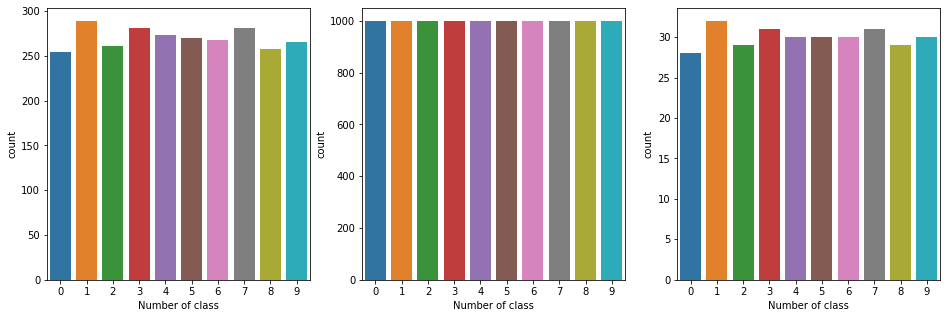

In [34]:
fig, axes = plt.subplots(1, 3, figsize = (16, 5))
x_lab = 'Number of class'

axes[0].set(xlabel = x_lab)
axes[1].set(xlabel = x_lab)
axes[2].set(xlabel = x_lab)

sns.countplot(Y_train, ax = axes[0])
sns.countplot(Y_test, ax = axes[1])
sns.countplot(Y_val, ax = axes[2])

### Image uniformity

- Here we check greyscale value distribution, to see if it depends on the class. This is done for further data processing, e.g. standartization
- Conclusions:
    - Min = 0, Max = 255 (Greyscale value)
    - Distribution of greyscale value is bimodal. Two modes:
        - ~0
        - ~220-230
    - Big difference in modes' amplitude -> it is reasonable to preprocess images with standartization / scaling

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

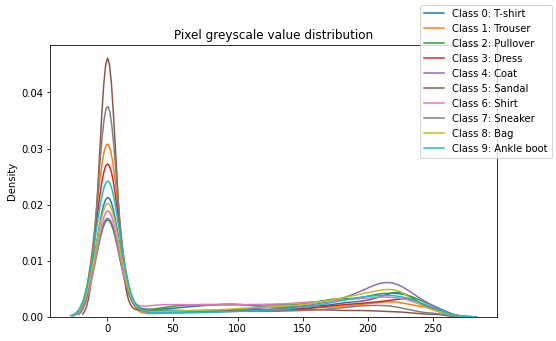

In [37]:
compare_pixel_dist(X_train, 
                   Y_train,
                   classes = DataProperties.classes,
                   sample_size = 150
)

### Image visualization

- Visualize images of clothes, related to class numbers from 0 to 9
- Conclusions:
        0: 'T-shirt',
        1: 'Trouser', 
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal', 
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot'

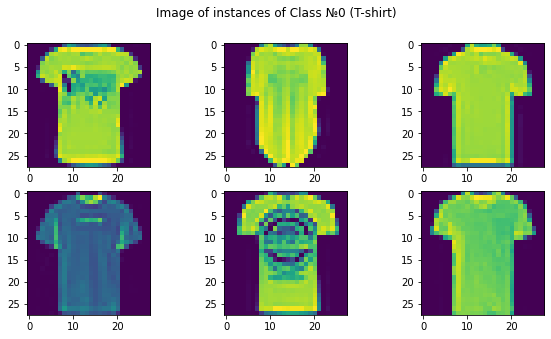

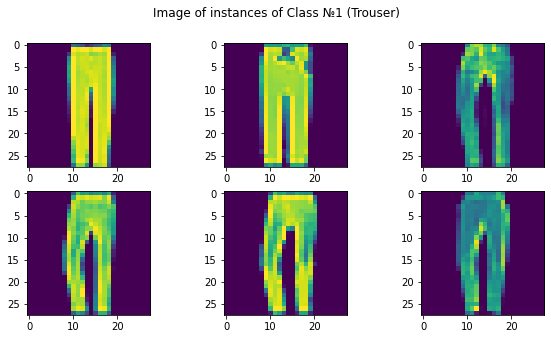

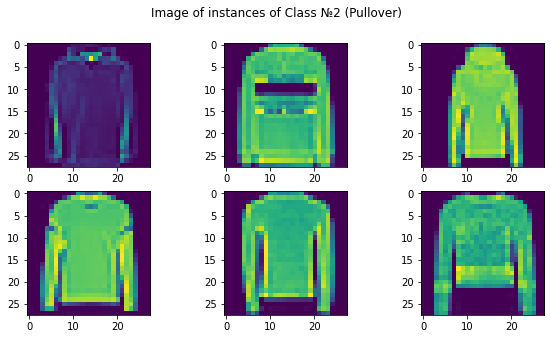

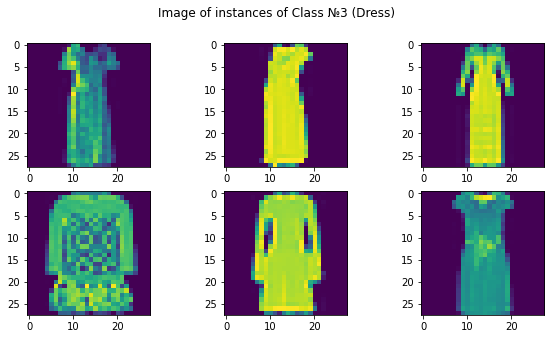

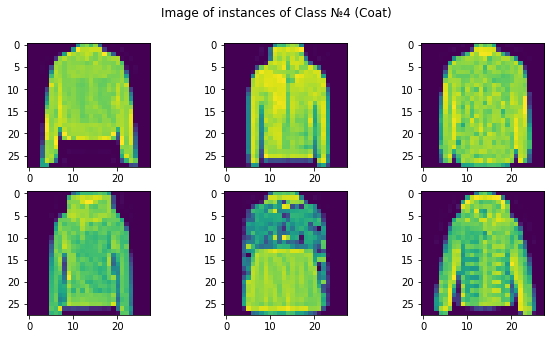

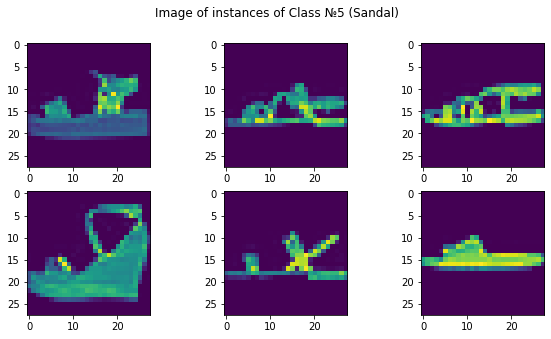

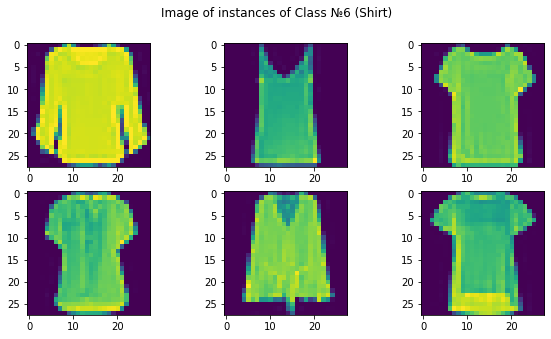

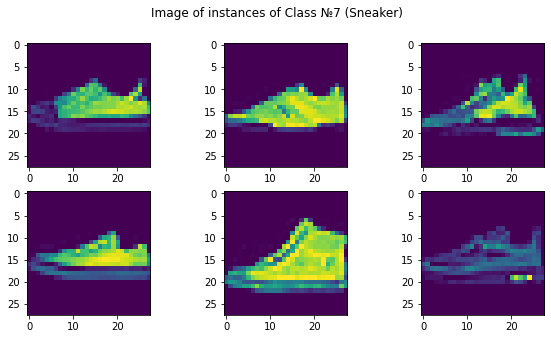

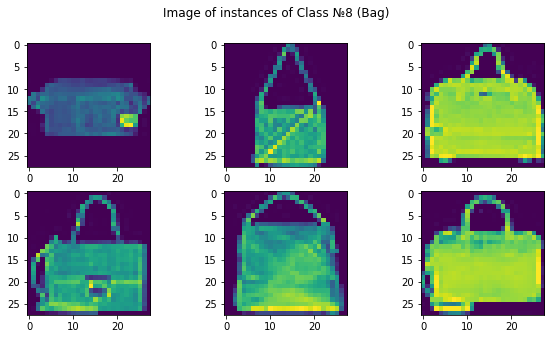

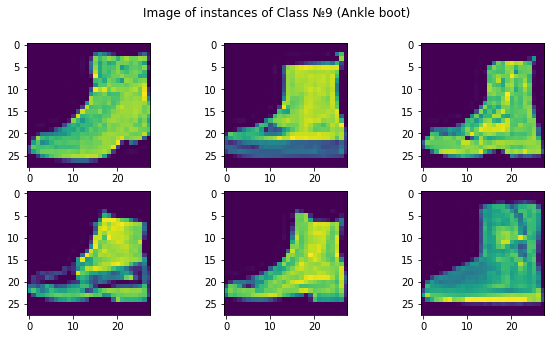

In [36]:
for class_n in range(10):
    plot_class(
        class_n,
        X = X_train,
        Y = Y_train,
        figsize = (10, 5),
        matsize = (2, 3)
    )

# Data preprocessing

- Conclusions:
    - Clean dataset (No NAN values)
    - Images as input (No subdivision on categorical, data -> no preprocessing with encoding)
    - No color channel (Gray images, already flattened)
- After applying preprocessing, we can see:
    - How it changes distribution of pixels brightness
    - How it affects visual perception of the image

### Preprocessing

#### Experiment with HOG transform

Here we demonstrate the effect of HOG transformation. Because of small size of images, HOG preprocessing does not give better effect

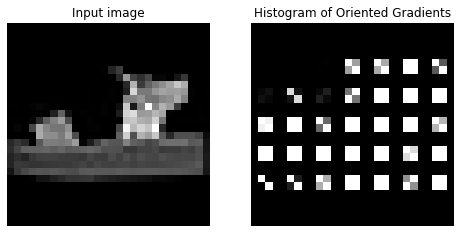

(28, 28) (28, 28)


In [38]:
from skimage.feature import hog
from skimage import data, exposure


image = np.array(X_train[1]).reshape(28, 28)

fd, hog_image = hog(
    image, 
    orientations=8, 
    pixels_per_cell=(4, 4),
    cells_per_block=(3, 3), 
    visualize=True
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()
print(hog_image.shape, hog_image_rescaled.shape)

#### Pipeline

In [39]:
preproc_pipeline = Pipeline(
    [
        ('reshape', Reshaper()),
        
        # Sobel edge highlight
        ('highlight edges', EdgeHighlighter(add_coef = 50)),  
     
        #('hog', HogTransformer()), # Did not work well
        ('flatten', Flatter()),
        ('scaler', StandardScaler())
    ]
)

X_train = preproc_pipeline.fit_transform(X_train)
X_val = preproc_pipeline.transform(X_val)
X_test = preproc_pipeline.transform(X_test)

### Visualization after preprocessing

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

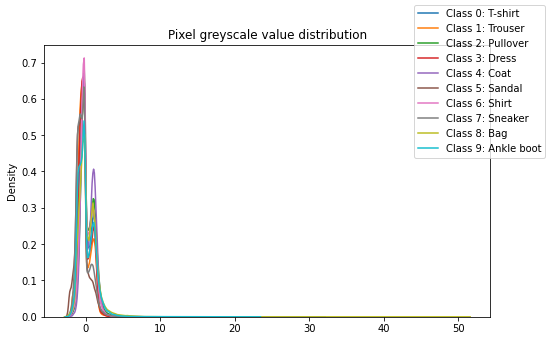

In [40]:
# Distribution changed after preprocessing
compare_pixel_dist(X_train, 
                   Y_train,
                   classes = DataProperties.classes,
                   sample_size = 150
)

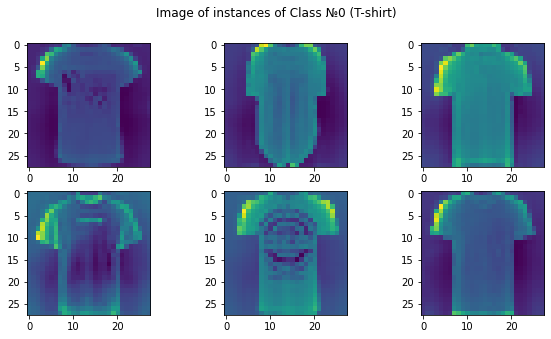

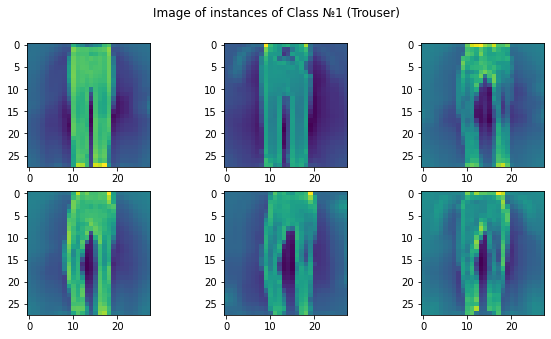

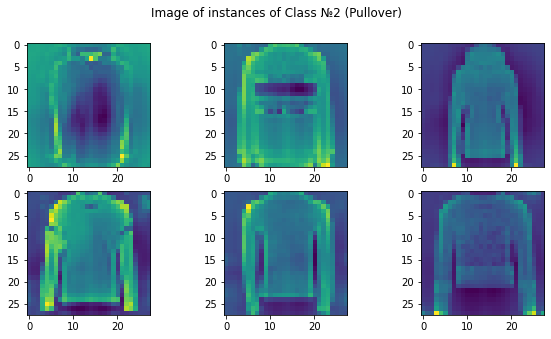

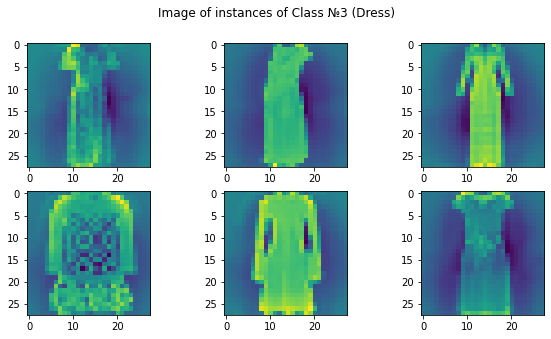

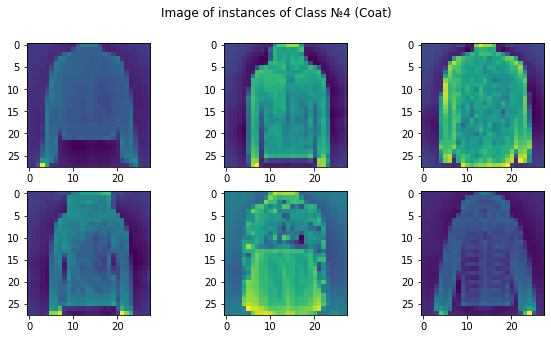

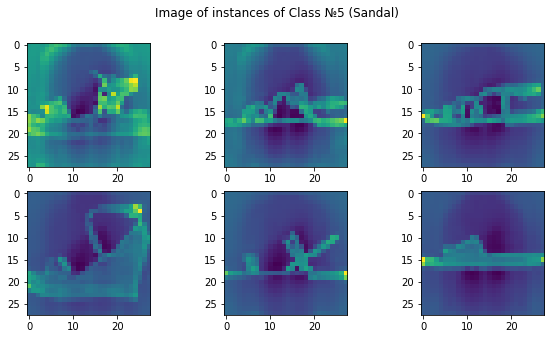

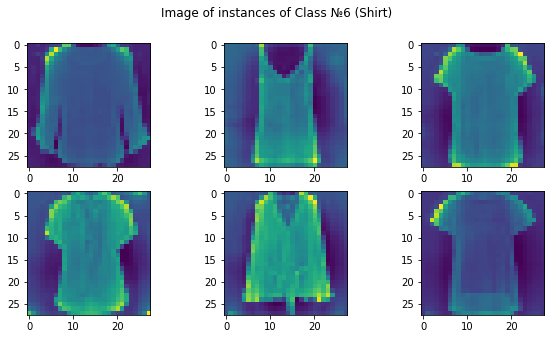

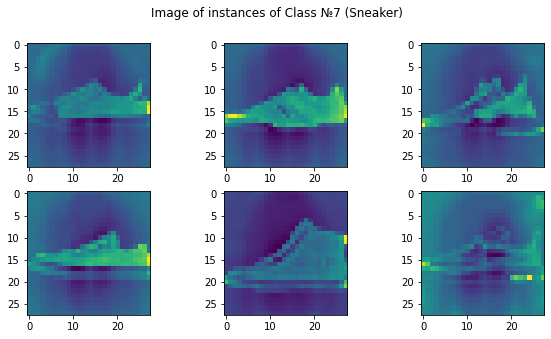

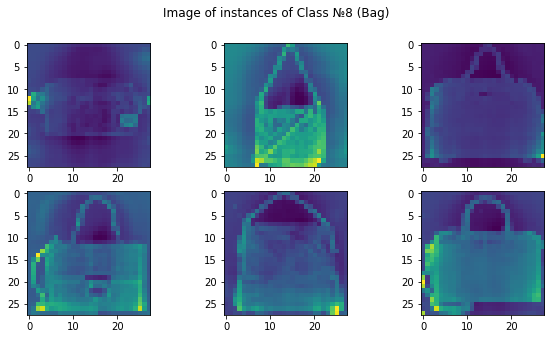

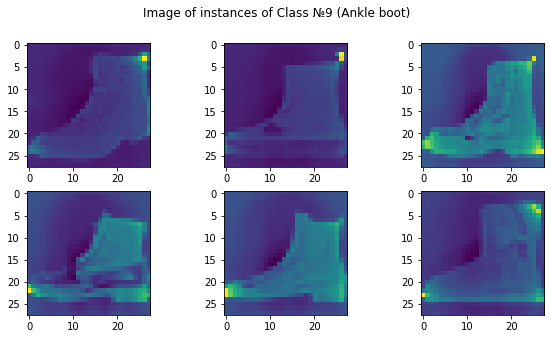

In [41]:
for class_n in range(10):
    plot_class(
        class_n,
        X = X_train,
        Y = Y_train,
        figsize = (10, 5),
        matsize = (2, 3)
    )

# Model training

- To avoid redundancy, all search procedures and parameter grids are encapsulated inside classes, inherited from GSModel (Grid Search Model) class
- Resulting models will be compared based on several metrics for multiclass classification:
    - Accuracy
    - ROC-AUC
    - F1 
    - Precision & Recall
    - Confusion matrix analysis
- In the later part, we show that F1, Accuracy, Precision and Recall are almost identical in values. Therefore, any of these metrics can be applied on gridsearch CV
- Cross validation parameters for compared models are kept identical (cv = 5)

### Models Training (Cross Validation)

In [43]:
scorers = {
    'Accuracy': make_scorer(accuracy_score),
    'F1': 'f1_macro'
}

models = [
    # XGBModel()  # Extremely long
    RandomForestModel(),  # Random forest
    SVMModel(),  # SVM
    DTModel()  # Decision tree
]

cv_results = {}

for model in models:
    clf = GridSearchCV(
        model.clf,
        model.get_grid(),
        scoring = scorers,  # Several metrics to track
        refit = 'F1',  # Score used to find best parameters (among several metrics)
        return_train_score = True,  # Explore train behaviour
        **model.get_search_parameters()
    )
    clf.fit(X_train, Y_train)
    cv_results.update({model.name: clf})

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


# Model comparison

### Best score comparison

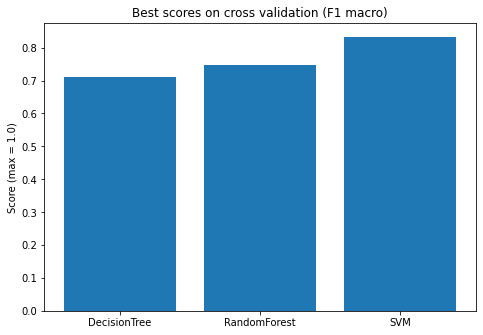

In [44]:
best_scores = get_best_scores(cv_results)
plot_best_scores(
    best_scores,
    y_label = 'Score (max = 1.0)',
    title = 'Best scores on cross validation (F1 macro)'
)

### Average CV train & CV test performance

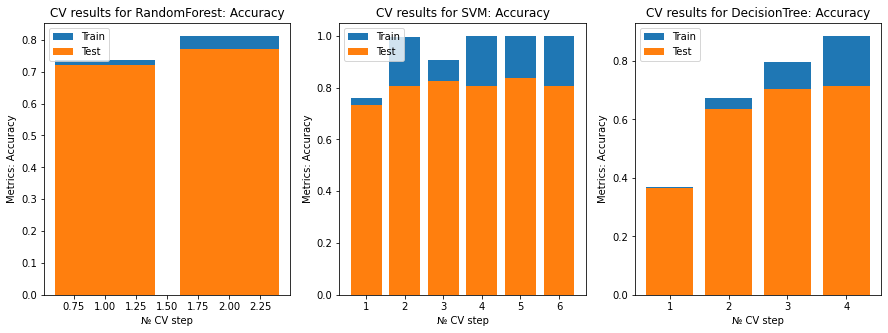

In [45]:
plot_cv_metrics(
    cv_results,
    metrics_name = 'Accuracy',
    figsize = (15, 5),
    layout_shape = (1, 3)
)

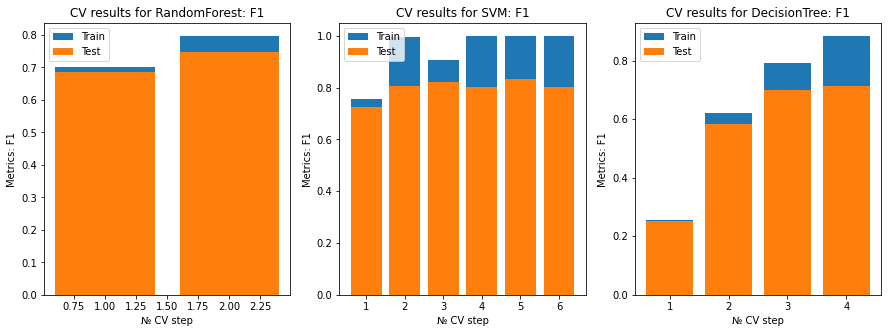

In [46]:
plot_cv_metrics(
    cv_results,
    metrics_name = 'F1',
    figsize = (15, 5),
    layout_shape = (1, 3)
)

### Learning curves for best estimators, comparison

Here, we plot learning curves for chosen models. Since plotting learning curves requires models re-fit on several subsets of data (e.g. 5%, 10%, ... 95%, 100%), it is the most time-consuming operation.
Therefore, the presented learning curves **correspond to a smaller subset of training data**

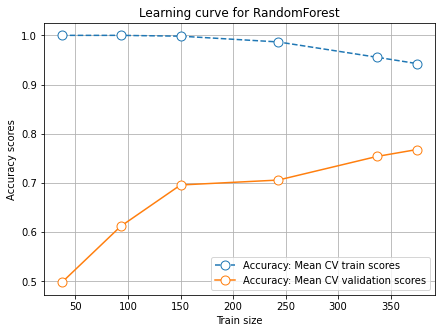

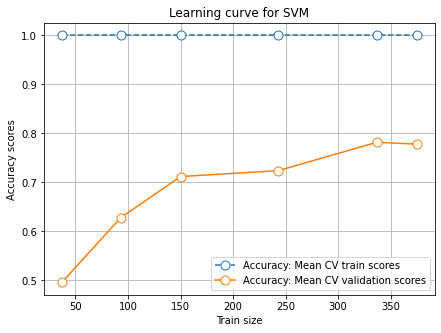

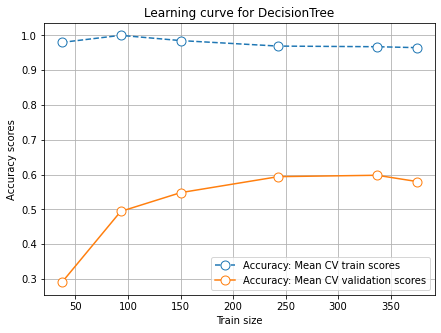

In [47]:
subset_size = 500

for model_name, res in cv_results.items():
    model = res.best_estimator_
    plot_learning_curve(
        model = res.best_estimator_,
        model_name = model_name,
        X = X_train[: subset_size],
        Y = Y_train[: subset_size],
        train_sizes = [0.1, 0.25, 0.4, 0.65, 0.9, 1.0],
        cv = 4,
        scoring = 'accuracy',
        metrics_name = 'Accuracy'
    )

### Confusion matrix analysis

#### Models confusion matrices

Here, we make several important conclusions:
- Weakly-learned models mistake one type of clothes for another. For example, for a train set of 200 objects (purposely weakly-learned models), mistakenly classified models:
    - Predicted: T-shirt, True: Dress (15%)
    - Predicted: T-shirt, True: Shirt (26%)
    - Predicted: Coat, True: Pullover (28%)
    - Predicted: Sneaker, True: Sandal (17%)
This is an important insight. For a real task, an additional data (e.g. about materials used (leather, fluff, cotton)) will help to distinguish between **winter** and **summer** clothes.


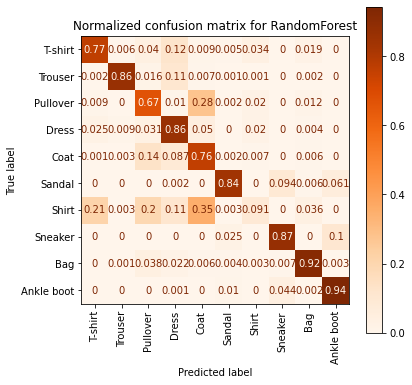

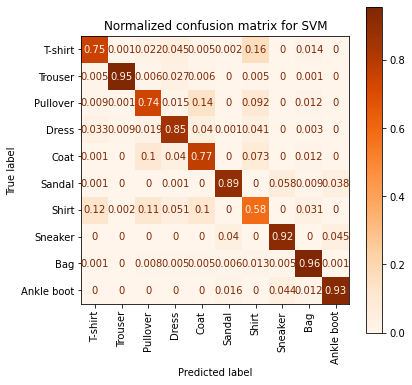

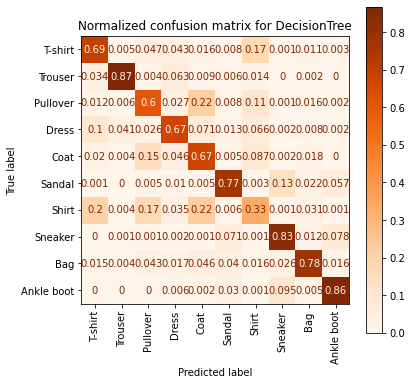

In [48]:
for model_name, model in cv_results.items():
    plot_confusion_matrix(
        model,
        model_name,
        X_test,
        Y_test, 
        figsize = (6, 6)
    )

#### Examples of mistaken images

- Below a subset of classification mistakes is presented. Each class from 0 to 9, we consider as a true label. Then, look for **top_n** mistaken labels. Hence, we cover all possible pairs in confusion matrix with the highest mistake rate.
- Analysis of mistaken images provides several important insights. Thus, the most mistaken class pairs are:
    - T-shirt & Shirt
    - Pullover & Coat
    - Pullover & Dress
    - Sneaker & Ankle boot
    - Sandal & Ankle boot
    - etc.
- We see how clothes of similar look can be easily misclassified. If it was a commercial task, an additional dataset on materials used (#, fluff, cotton, leather) will help to reduce mistakes.

##### SVM model

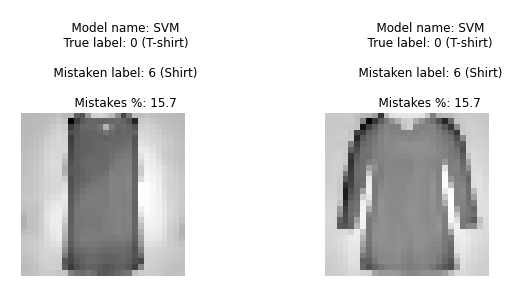

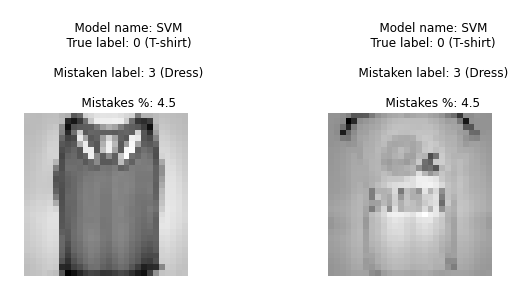

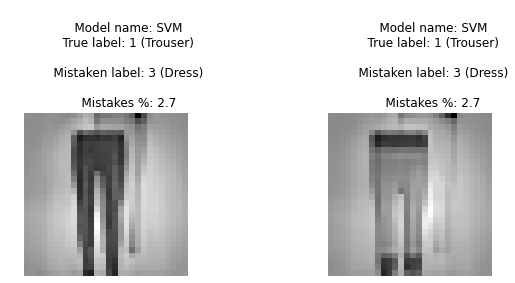

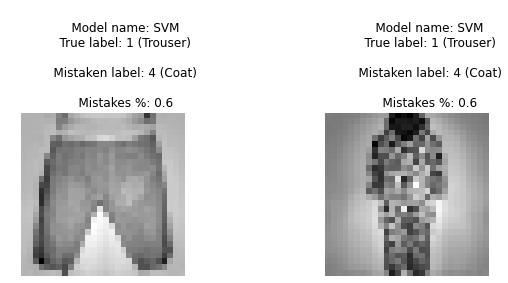

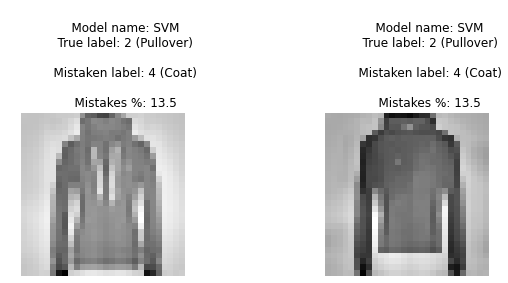

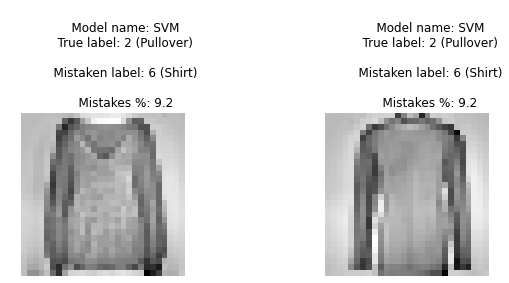

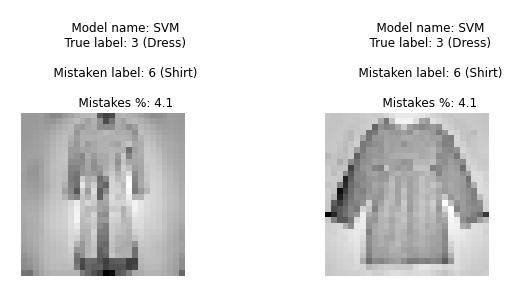

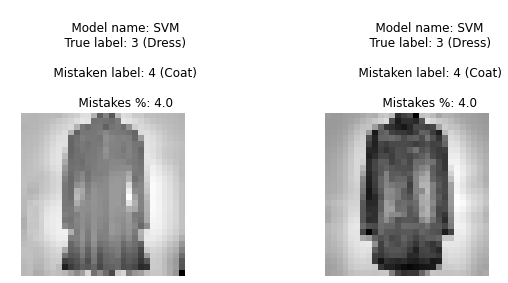

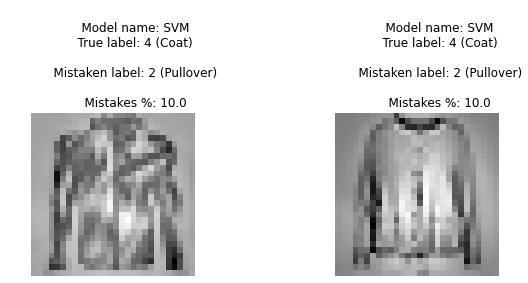

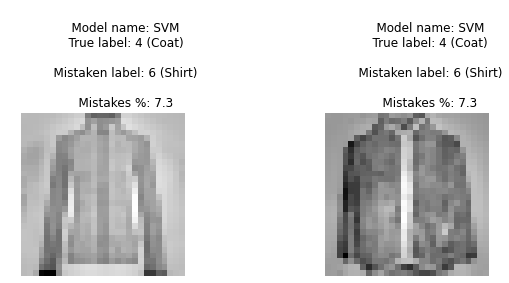

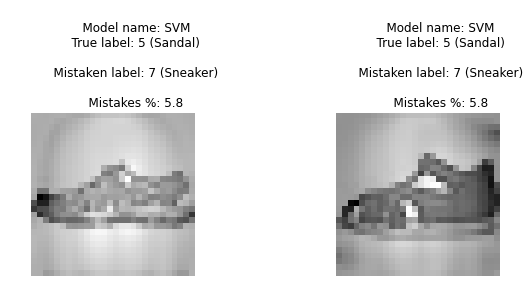

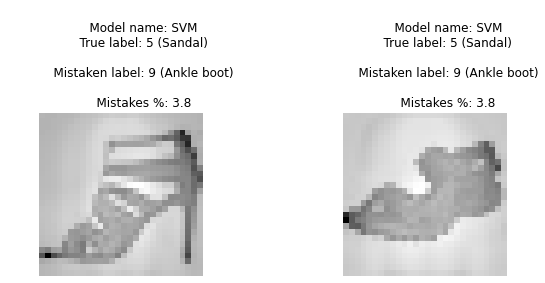

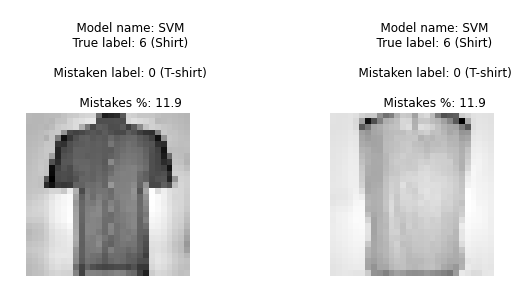

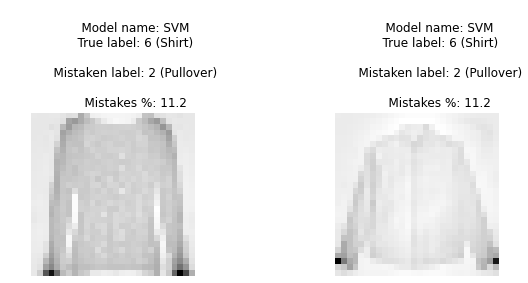

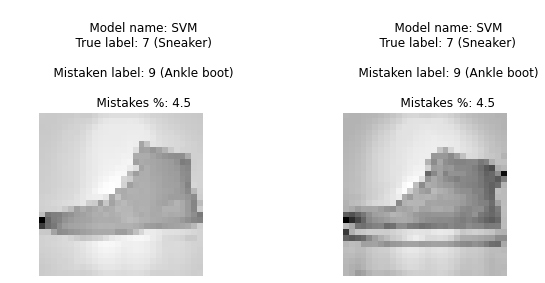

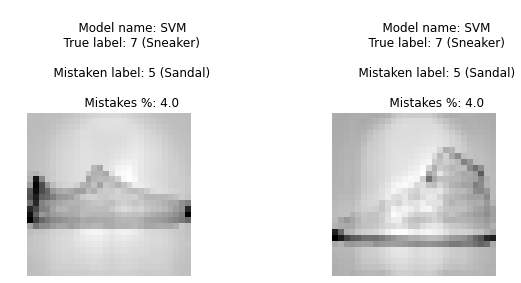

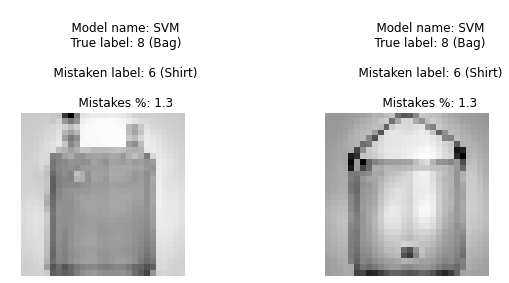

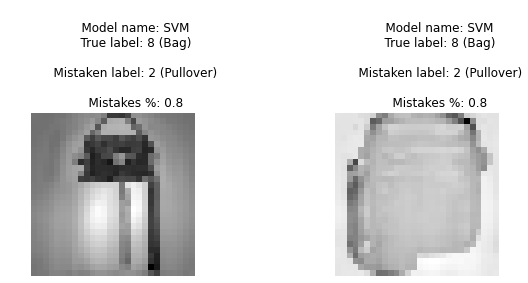

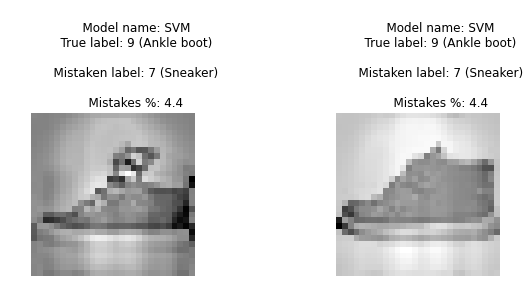

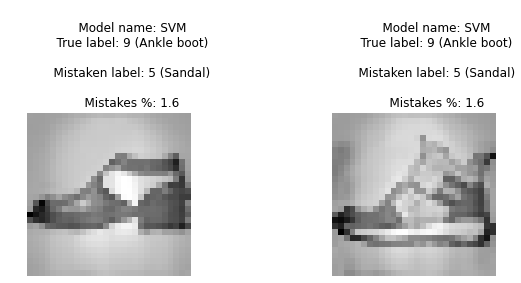

In [49]:
name = 'SVM'

plot_mistakes(
    best_estimator = cv_results[name].best_estimator_,
    model_name = name,
    X = X_test,
    Y_true = Y_test,
    Y_predicted = cv_results[name].best_estimator_.predict(X_test),
    top_n = 2  # Show top_n mistaken classes
)

##### Random forest model

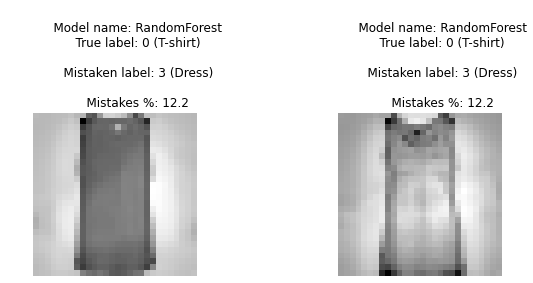

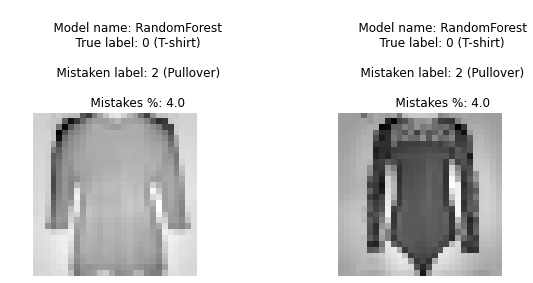

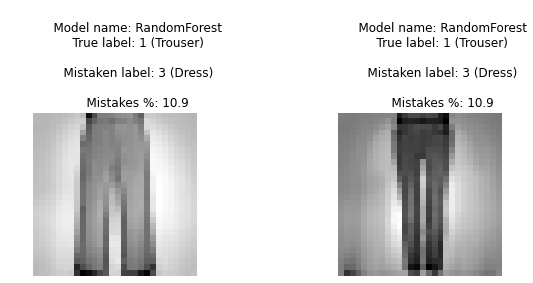

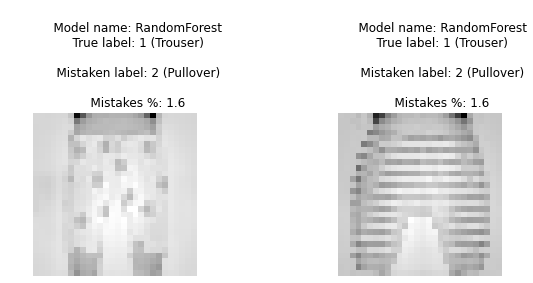

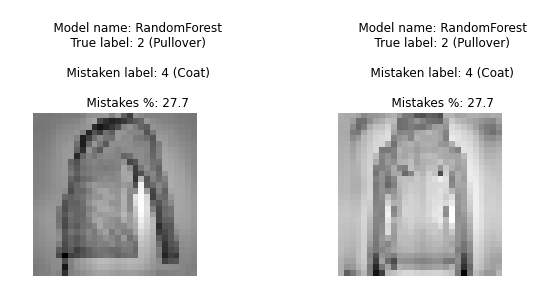

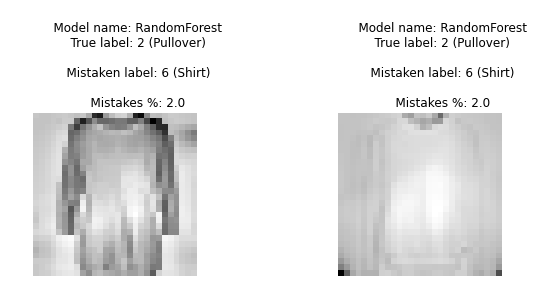

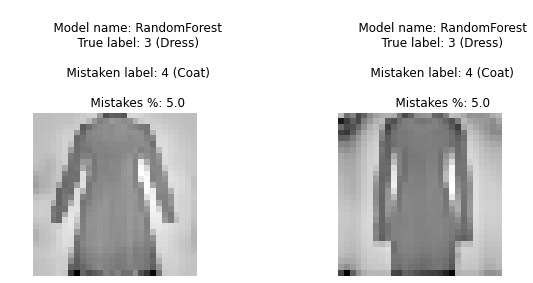

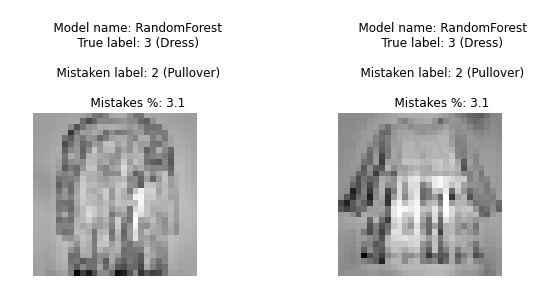

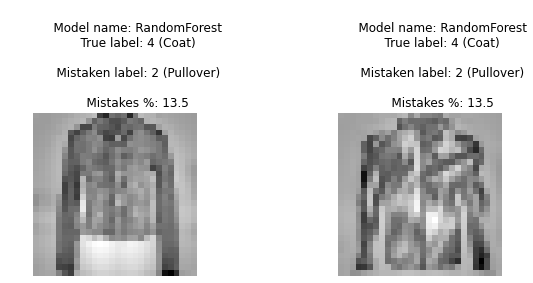

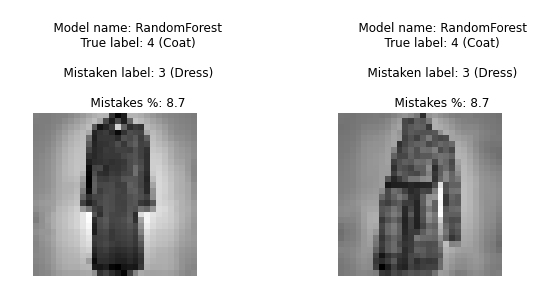

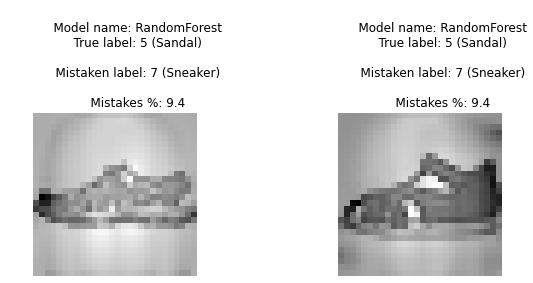

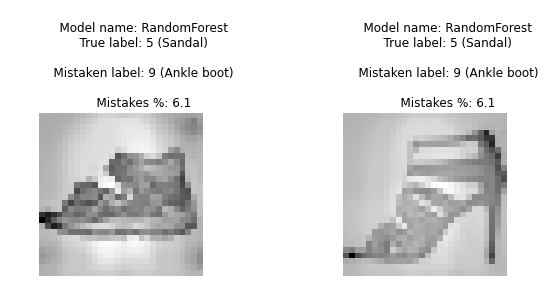

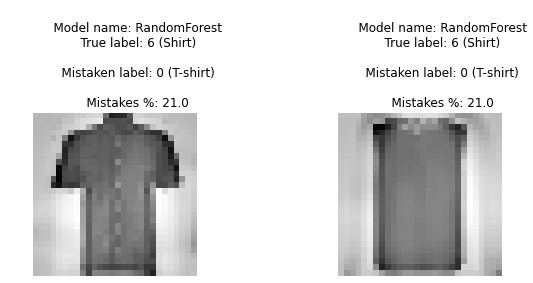

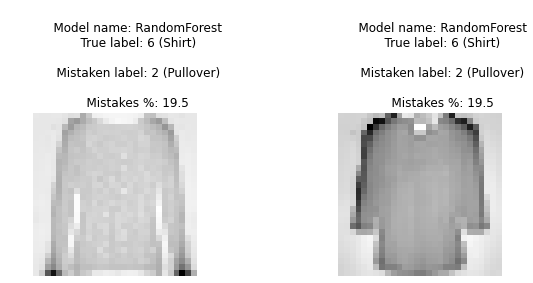

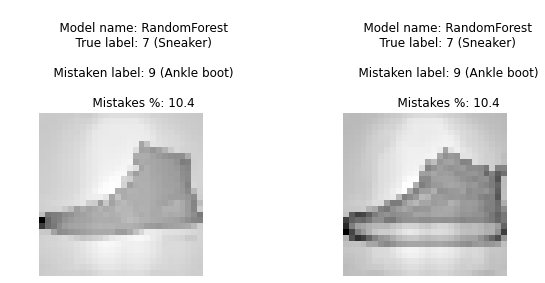

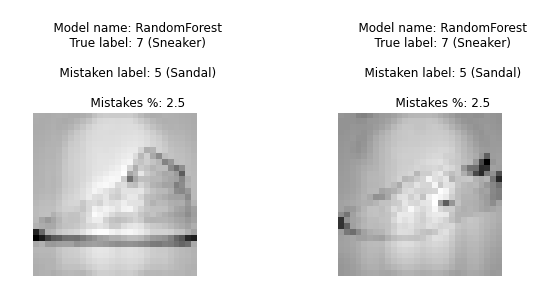

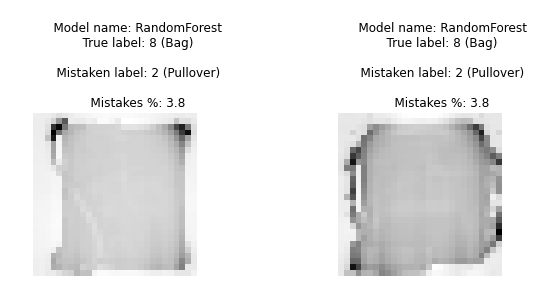

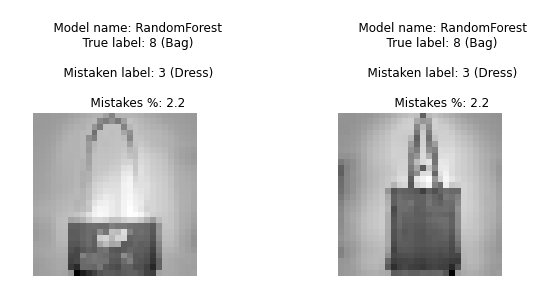

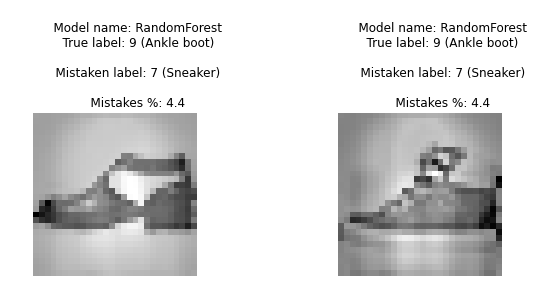

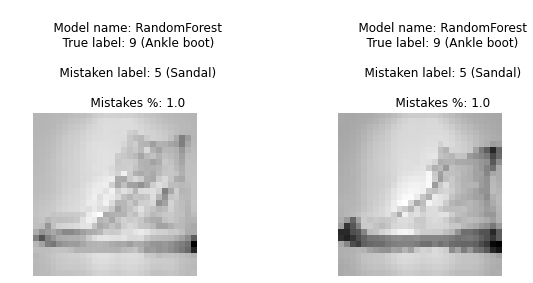

In [50]:
name = 'RandomForest'

plot_mistakes(
    best_estimator = cv_results[name].best_estimator_,
    model_name = name,
    X = X_test,
    Y_true = Y_test,
    Y_predicted = cv_results[name].best_estimator_.predict(X_test),
    top_n = 2  # Show top_n mistaken classes
)

##### Decision tree model

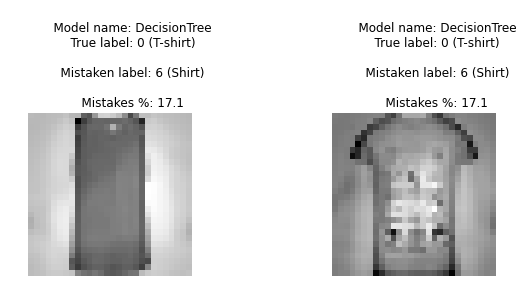

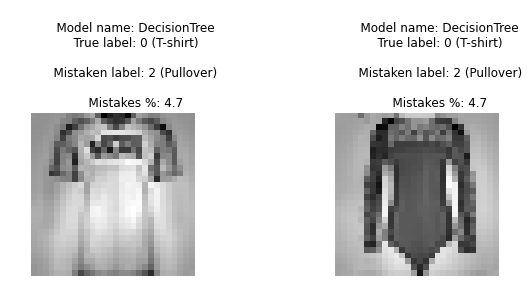

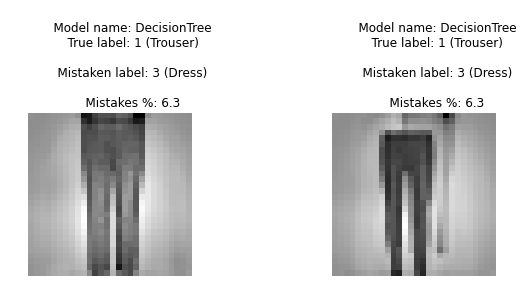

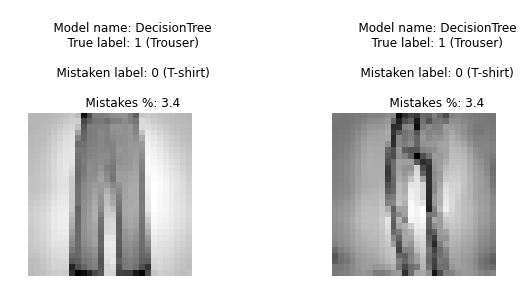

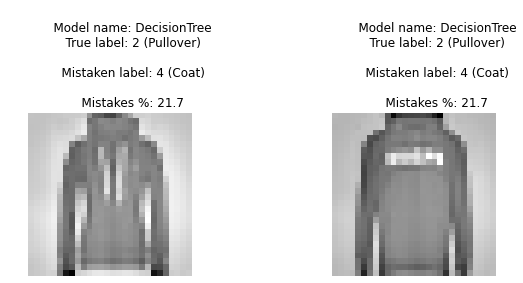

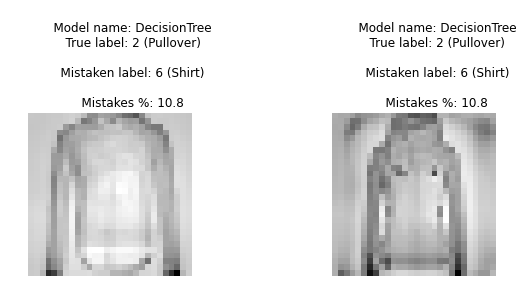

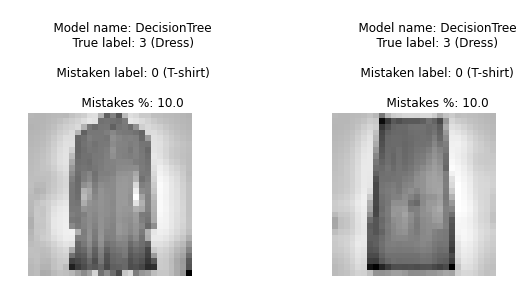

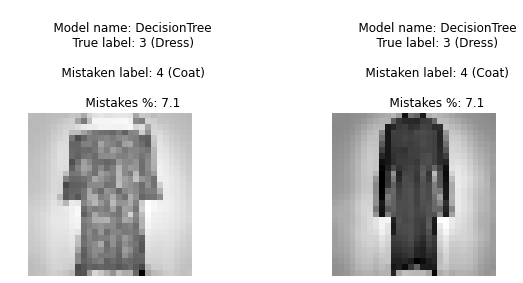

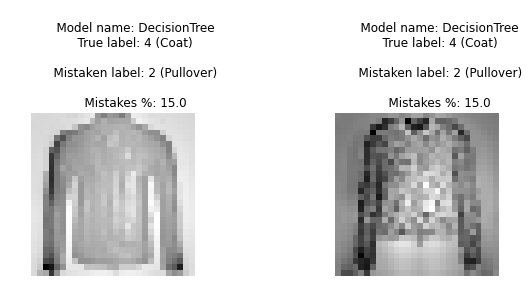

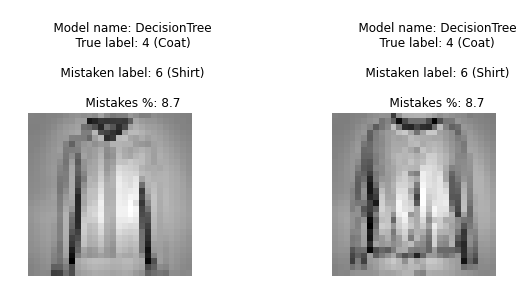

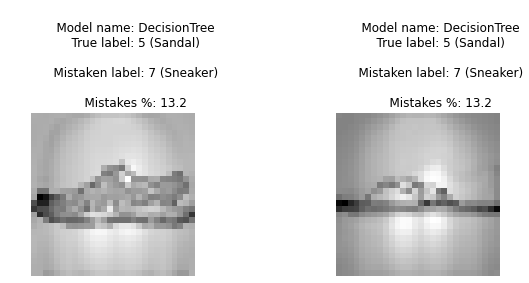

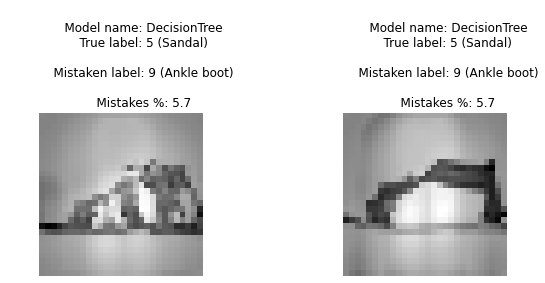

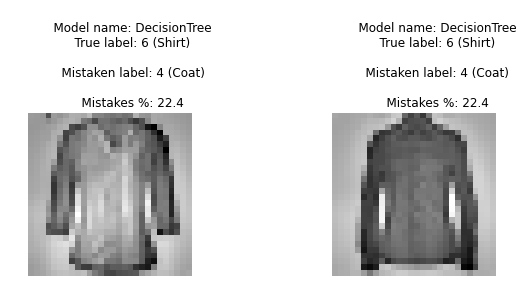

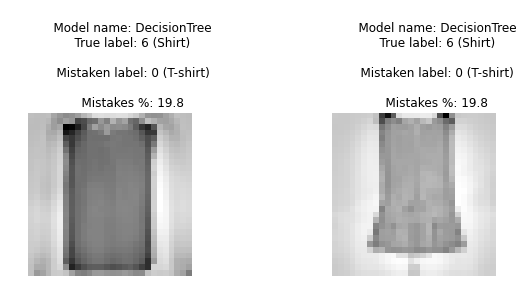

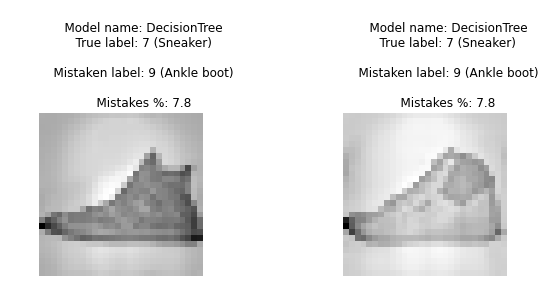

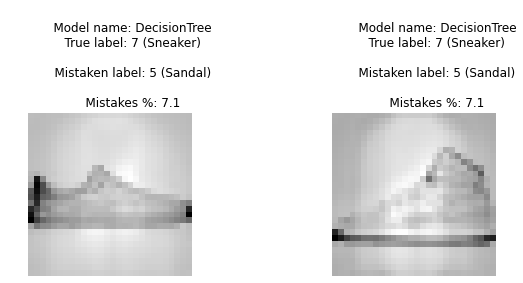

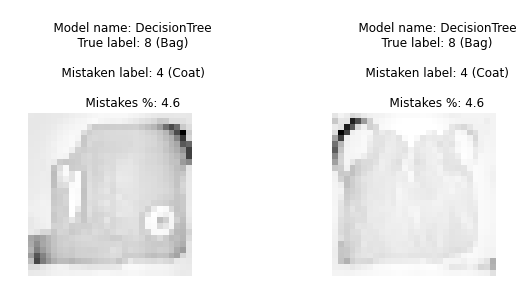

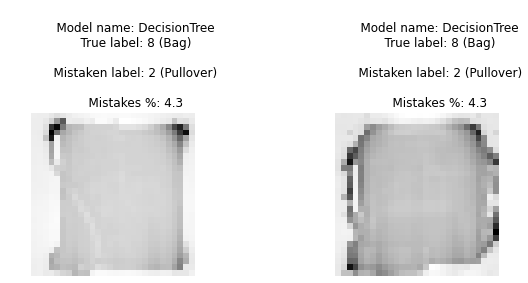

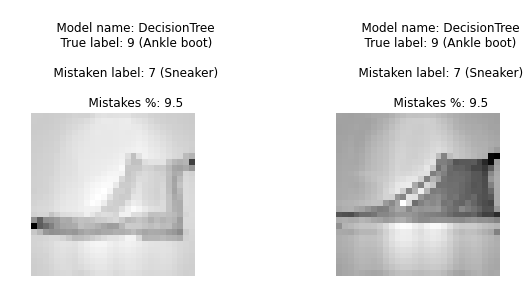

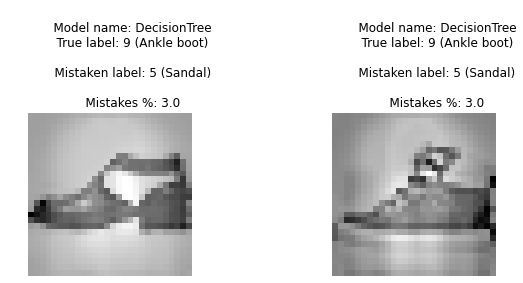

In [51]:
name = 'DecisionTree'

plot_mistakes(
    best_estimator = cv_results[name].best_estimator_,
    model_name = name,
    X = X_test,
    Y_true = Y_test,
    Y_predicted = cv_results[name].best_estimator_.predict(X_test),
    top_n = 2  # Show top_n mistaken classes
)

# Neural network approach

### Construct & compile model

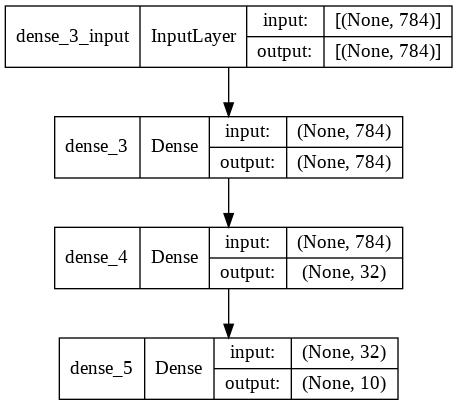

In [70]:
def construct_nn_model(input_dimension, learning_rate):
    np.random.seed(DataProperties.seed)
    set_random_seed(DataProperties.seed)

    stopper = EarlyStopping(
        monitor = 'val_accuracy',
        mode = 'max',
        patience = 2,
        verbose = 1
    )

    Model = Sequential()
    Model.add(Dense(input_dim = input_dimension, units = input_dimension, activation = 'relu'))
    Model.add(Dense(units = 32, activation = 'relu'))
    Model.add(Dense(units = DataProperties.num_classes, activation = 'softmax'))

    Model.compile(
        loss = 'categorical_crossentropy',
        optimizer = SGD(learning_rate = learning_rate), 
        # optimizer = Adam(learning_rate = 0.001), - Bad learning curves
        metrics = ['accuracy']
    )
    
    return Model

NNModel = construct_nn_model(
    input_dimension = X_train.shape[1],
    learning_rate = 0.004
)

plot_model(NNModel, show_shapes = True)

### Encode target values

In [53]:
Y_train_nn = to_categorical(Y_train, num_classes = DataProperties.num_classes)
Y_test_nn = to_categorical(Y_test, num_classes = DataProperties.num_classes)

### Train model

In [54]:
history = NNModel.fit(
    X_train,
    Y_train_nn,
    epochs = 500,
    batch_size = 16,
    verbose = 1,
    validation_split = 0.2,
    callbacks = [stopper]
)

Epoch 1/500
135/135 [==============================] - 3s 6ms/step - loss: 1.2705 - accuracy: 0.6009 - val_loss: 0.8905 - val_accuracy: 0.7204
Epoch 2/500
135/135 [==============================] - 1s 4ms/step - loss: 0.7090 - accuracy: 0.7755 - val_loss: 0.7391 - val_accuracy: 0.7537
Epoch 3/500
135/135 [==============================] - 1s 5ms/step - loss: 0.5720 - accuracy: 0.8162 - val_loss: 0.6654 - val_accuracy: 0.7778
Epoch 4/500
135/135 [==============================] - 1s 5ms/step - loss: 0.4918 - accuracy: 0.8375 - val_loss: 0.6335 - val_accuracy: 0.8000
Epoch 5/500
135/135 [==============================] - 1s 5ms/step - loss: 0.4347 - accuracy: 0.8606 - val_loss: 0.6050 - val_accuracy: 0.7944
Epoch 6/500
135/135 [==============================] - 1s 4ms/step - loss: 0.3918 - accuracy: 0.8764 - val_loss: 0.5992 - val_accuracy: 0.8019
Epoch 7/500
135/135 [==============================] - 1s 5ms/step - loss: 0.3573 - accuracy: 0.8856 - val_loss: 0.5879 - val_accuracy: 0.8130

### Plot learning curve

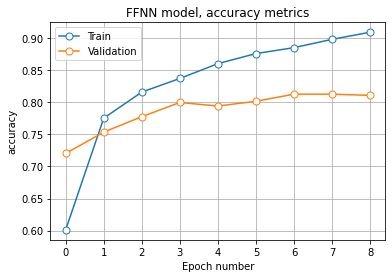

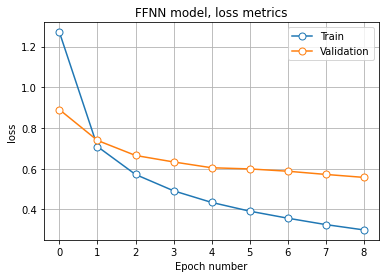

In [55]:
plot_nn_learning_curve(
    history.history,
    metrics_name = 'accuracy',
    val_metrics_name = 'val_accuracy'
)

plot_nn_learning_curve(
    history.history,
    metrics_name = 'loss',
    val_metrics_name = 'val_loss'
)

# Choose best model on validation set

In GridSearchCV we compared all models except for neural network. In the final step, we will compare best models with Neural Network, based on several metrics
- Accuracy (valid, since data is balanced)
- Precision
- Recall
- F1 score

In [56]:
best_estimators_dict = {
    name: item.best_estimator_ for name, item in cv_results.items()
}
best_estimators_dict['NeuralNetwork'] = NNModel

precisions, recalls, accuracies, F1 = collect_classif_reports(
    best_estimators_dict,
    X = X_val,
    Y = Y_val
)

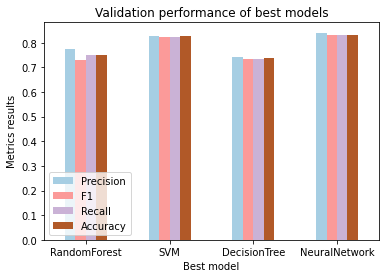

In [57]:
final_metrics = pd.DataFrame.from_dict(precisions, orient='index', columns = ['Precision'])
final_metrics['F1'] = F1.values()
final_metrics['Recall'] = recalls.values()
final_metrics['Accuracy'] = accuracies.values()

ax = final_metrics.plot.bar(
    rot = 0,
    xlabel = 'Best model',
    ylabel = 'Metrics results',
    cmap = 'Paired',
    title = 'Validation performance of best models'
)
ax.legend(loc = 3)

# Best model test performance

- Refit on train + validation 
- Report final results on unseen test set

In [83]:
#final_model = NNModel
X_final = np.vstack([X_train, X_val])
Y_final = np.concatenate([Y_train, Y_val])
X_final.shape, Y_final.shape

((3000, 784), (3000,))

In [86]:
best_model = NNModel
best_model.fit(X_final, Y_final)

precisions, recalls, accuracies, F1 = collect_classif_reports(
    {'Final Model': NNModel},
    X = X_test,
    Y = Y_test
)

TypeError: ignored

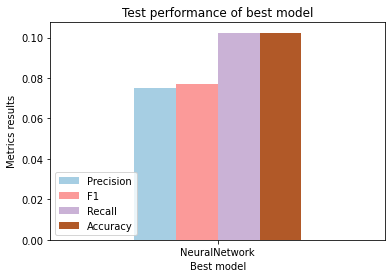

In [85]:
final_metrics = pd.DataFrame.from_dict(fin_precisions, orient='index', columns = ['Precision'])
final_metrics['F1'] = fin_F1.values()
final_metrics['Recall'] = fin_recalls.values()
final_metrics['Accuracy'] = fin_accuracies.values()

ax = final_metrics.plot.bar(
    rot = 0,
    xlabel = 'Best model',
    ylabel = 'Metrics results',
    cmap = 'Paired',
    title = 'Test performance of best model'
)
ax.legend(loc = 3)